In [1]:
from rtt_tools import dump_data
import collections
import json
import re
import os
import math
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib
import random
import itertools

import networkx as nx
import matplotlib.pyplot as plt
import graphviz
from graphviz import Digraph, Graph

2019-04-30 13:33:57 aura.fi.muni.cz matplotlib[119329] DEBUG $HOME=/home/xklinec
2019-04-30 13:33:57 aura.fi.muni.cz matplotlib[119329] DEBUG CONFIGDIR=/home/xklinec/.config/matplotlib
2019-04-30 13:33:57 aura.fi.muni.cz matplotlib[119329] DEBUG matplotlib data path: /home/xklinec/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/mpl-data
2019-04-30 13:33:57 aura.fi.muni.cz matplotlib[119329] DEBUG loaded rc file /home/xklinec/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc
2019-04-30 13:33:57 aura.fi.muni.cz matplotlib[119329] DEBUG matplotlib version 3.0.2
2019-04-30 13:33:57 aura.fi.muni.cz matplotlib[119329] DEBUG interactive is False
2019-04-30 13:33:57 aura.fi.muni.cz matplotlib[119329] DEBUG platform is linux
2019-04-30 13:33:57 aura.fi.muni.cz matplotlib[119329] DEBUG loaded modules: ['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimpor

2019-04-30 13:33:58 aura.fi.muni.cz matplotlib[119329] DEBUG CACHEDIR=/home/xklinec/.cache/matplotlib
2019-04-30 13:33:58 aura.fi.muni.cz matplotlib.font_manager[119329] DEBUG Using fontManager instance from /home/xklinec/.cache/matplotlib/fontlist-v300.json
2019-04-30 13:33:58 aura.fi.muni.cz matplotlib.pyplot[119329] DEBUG Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2019-04-30 13:33:59 aura.fi.muni.cz matplotlib.pyplot[119329] DEBUG Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
loader = dump_data.Loader()

In [3]:
loader.load({'no_pvals':True, 'only_pval_cnt': True, 'experiments': [2,3,4,5,7,8]})

2019-04-30 13:34:15 aura.fi.muni.cz rtt_tools.dump_data[119329] DEBUG Unparsed: ['-f', '/home/xklinec/.local/share/jupyter/runtime/kernel-f64fb27e-b835-492b-8385-b34635ff4f5b.json']
2019-04-30 13:34:15 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all experiments
2019-04-30 13:34:15 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Number of all experiments: 3958
2019-04-30 13:34:15 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all batteries, len: 3958
2019-04-30 13:34:16 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all tests, len: 27705
2019-04-30 13:34:16 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:34:16 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:34:16 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:34:16 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len

2019-04-30 13:34:30 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:34:30 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:34:30 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:34:30 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:34:31 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:34:31 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:34:31 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest params, len: 10000
2019-04-30 13:34:31 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest stats, len: 10000
2019-04-30 13:34:32 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:34:32 aura.fi.muni.

2019-04-30 13:34:45 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest stats, len: 10000
2019-04-30 13:34:45 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:34:45 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:34:46 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:34:46 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:34:46 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:34:46 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:34:46 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest params, len: 10000
2019-04-30 13:34:46 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest stats, len: 10000
2019-04-30 13:34:47 aura.fi.muni.

2019-04-30 13:35:00 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest params, len: 10000
2019-04-30 13:35:00 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest stats, len: 10000
2019-04-30 13:35:01 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:35:01 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:35:01 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:35:01 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:35:01 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest params, len: 10000
2019-04-30 13:35:01 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest stats, len: 10000
2019-04-30 13:35:02 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:35:02 aura.fi.muni.

2019-04-30 13:35:16 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:35:16 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest params, len: 10000
2019-04-30 13:35:16 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest stats, len: 10000
2019-04-30 13:35:16 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:35:16 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:35:17 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:35:17 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:35:17 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest params, len: 10000
2019-04-30 13:35:17 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest stats, len: 10000
2019-04-30 13:35:17 aura.fi.muni.

2019-04-30 13:35:31 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:35:31 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest params, len: 10000
2019-04-30 13:35:31 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest stats, len: 10000
2019-04-30 13:35:31 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:35:31 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:35:31 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:35:32 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:35:32 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:35:32 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest params, len: 10000
2019-04-30 13:35:32 aura.fi.muni.

2019-04-30 13:35:46 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:35:46 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest params, len: 10000
2019-04-30 13:35:46 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest stats, len: 10000
2019-04-30 13:35:47 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:35:47 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:35:47 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:35:47 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:35:47 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:35:47 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest params, len: 10000
2019-04-30 13:35:48 aura.fi.muni.

2019-04-30 13:36:00 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:36:00 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:36:00 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:36:00 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest params, len: 10000
2019-04-30 13:36:01 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest stats, len: 10000
2019-04-30 13:36:03 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:36:03 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:36:04 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:36:04 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:36:04 aura.fi.muni.

2019-04-30 13:36:17 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:36:17 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:36:17 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest params, len: 10000
2019-04-30 13:36:17 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest stats, len: 10000
2019-04-30 13:36:17 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:36:17 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:36:18 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:36:18 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:36:18 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest params, len: 10000
2019-04-30 13:36:18 aura.fi.muni

2019-04-30 13:36:33 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:36:33 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:36:33 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:36:33 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:36:33 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:36:33 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest params, len: 10000
2019-04-30 13:36:34 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest stats, len: 10000
2019-04-30 13:36:34 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:36:34 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:36:34 aura.fi.muni.

2019-04-30 13:36:46 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:36:47 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:36:47 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:36:47 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:36:47 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:36:47 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest params, len: 10000
2019-04-30 13:36:47 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest stats, len: 10000
2019-04-30 13:36:48 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:36:48 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:36:48 aura.fi.muni.

2019-04-30 13:37:03 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest stats, len: 10000
2019-04-30 13:37:04 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:37:04 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:37:04 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:37:04 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest params, len: 10000
2019-04-30 13:37:04 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all subtest stats, len: 10000
2019-04-30 13:37:05 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:37:05 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variant params, len: 2000
2019-04-30 13:37:05 aura.fi.muni.cz rtt_tools.dump_data[119329] INFO Loading all variants params, len: 1000
2019-04-30 13:37:05 aura.fi.muni.

In [4]:
#loader.process()
loader.add_passed = True
loader.comp_sub_pvals(add_all=True, pick_one=False)

In [5]:
loader.experiments[2893].exp_info.meth

'sac'

## Test categorization

In [6]:
# Data sizes -> tests -> test_config -> counts
test_configs = collections.defaultdict(
    lambda: collections.defaultdict(
        lambda: collections.defaultdict(
            lambda: 0
        )))

# Data sizes -> tests -> test_config -> config_data -> counts
test_configs_val = collections.defaultdict(
    lambda: collections.defaultdict(
        lambda: collections.defaultdict(
            lambda: collections.defaultdict(
                lambda: 0
        ))))


# data size -> test_flat -> counts
flat_configs_types = collections.defaultdict(
    lambda: collections.defaultdict(
            lambda: 0
        ))

# data size -> test_flat -> counts
flat_configs = collections.defaultdict(
    lambda: collections.defaultdict(
            lambda: 0
        ))

# Data sizes -> tests -> test_config+variantval -> counts
test_configs_var = collections.defaultdict(
    lambda: collections.defaultdict(
        lambda: collections.defaultdict(
            lambda: 0
        )))


for tt in loader.tests.values():
    exp = tt.battery.exp
    size = exp.exp_info.size
    tt_id = '|'.join(reversed(tt.short_desc()))

    for vv in tt.variants.values():
        cfs = '|'.join([str(x) for x in vv.settings.keys_tuple()])
        cfv = '|'.join([str(x) for x in vv.settings.values_tuple()])

        for ss in vv.sub_tests.values():
            tfs = '|'.join([str(x) for x in ss.params.keys_tuple()])
            tfv = '|'.join([str(x) for x in ss.params.values_tuple()])
            tcfg = '{%s}{%s}' % (cfs, tfs)
            tcfg_val = '{%s}{%s}' % (cfv, tfv)
            type_val = '[%s][%s]' % (tt_id, tcfg)
            var_val = '{%s}{%s}' % (cfs, cfv) 
            full_val = '[%s][%s][%s]' % (tt_id, tcfg, tcfg_val)

            test_configs[size][tt_id][tcfg] += 1
            test_configs['ALL'][tt_id][tcfg] += 1
            
            test_configs_var[size][tt_id][var_val] += 1
            test_configs_var['ALL'][tt_id][var_val] += 1
            
            test_configs_val[size][tt_id][tcfg][tcfg_val] += 1
            test_configs_val['ALL'][tt_id][tcfg][tcfg_val] += 1
            
            flat_configs[size][full_val] += 1
            flat_configs['ALL'][full_val] += 1
            flat_configs_types[size][type_val] += 1
            flat_configs_types['ALL'][type_val] += 1
            
            

In [7]:
print(json.dumps(test_configs_var, indent=2))

{
  "8589934592": {
    "TestU01 Block Alphabit|smultin_MultinomialBitsOver": {
      "{Bit NB|Bit R|Bit S|Bit W|Repetitions}{8388608000|0|32|1|1}": 1768,
      "{Bit NB|Bit R|Bit S|Bit W|Repetitions}{8388608000|0|32|2|1}": 1768,
      "{Bit NB|Bit R|Bit S|Bit W|Repetitions}{8388608000|0|32|4|1}": 1768,
      "{Bit NB|Bit R|Bit S|Bit W|Repetitions}{8388608000|0|32|8|1}": 1768,
      "{Bit NB|Bit R|Bit S|Bit W|Repetitions}{8388608000|0|32|16|1}": 1768,
      "{Bit NB|Bit R|Bit S|Bit W|Repetitions}{8388608000|0|32|32|1}": 1768
    },
    "TestU01 Block Alphabit|sstring_HammingIndep": {
      "{Bit NB|Bit R|Bit S|Bit W|Repetitions}{8388608000|0|32|1|1}": 884,
      "{Bit NB|Bit R|Bit S|Bit W|Repetitions}{8388608000|0|32|2|1}": 884,
      "{Bit NB|Bit R|Bit S|Bit W|Repetitions}{8388608000|0|32|4|1}": 884,
      "{Bit NB|Bit R|Bit S|Bit W|Repetitions}{8388608000|0|32|8|1}": 884,
      "{Bit NB|Bit R|Bit S|Bit W|Repetitions}{8388608000|0|32|16|1}": 884,
      "{Bit NB|Bit R|Bit S|Bit W|Repet

In [8]:
stables = set()
for msize in flat_configs_types:
    tests = flat_configs_types[msize]
    for t in tests:
        stables.add(t)
    
for msize in flat_configs_types:
    tests = flat_configs_types[msize]
    for test in tests:
        # other sizes
        for msize_other in [x for x in flat_configs_types if x != msize]:
            if test not in flat_configs_types[msize_other]:
                stables.discard(test)
                print('DIf: %10d->%10d: %s' % (msize, msize_other, test))
    #print(msize)
    
print('Stables....')
for xx in stables:
    printx('.. %s' % xx)

DIf: 8589934592->  10485760: [Dieharder|Marsaglia and Tsang GCD Test][{P-sample count}{}]
DIf: 8589934592->  10485760: [Dieharder|Byte Distribution][{P-sample count}{}]
DIf: 8589934592-> 104857600: [Dieharder|Byte Distribution][{P-sample count}{}]
DIf: 8589934592->  10485760: [Dieharder|DAB DCT][{P-sample count}{}]
DIf: 8589934592->  10485760: [Dieharder|DAB Fill Tree Test][{P-sample count}{}]
DIf: 8589934592-> 104857600: [Dieharder|DAB Fill Tree Test][{P-sample count}{}]
DIf: 8589934592->  10485760: [Dieharder|DAB Fill Tree Test 2][{P-sample count}{}]
DIf: 8589934592-> 104857600: [Dieharder|DAB Fill Tree Test 2][{P-sample count}{}]
DIf: 8589934592->  10485760: [Dieharder|DAB Monobit 2 Test][{P-sample count}{}]
DIf: 8589934592-> 104857600: [Dieharder|DAB Monobit 2 Test][{P-sample count}{}]
DIf: 8589934592->  10485760: [TestU01 Small Crush|smarsa_BirthdaySpacings][{Repetitions}{N|d|n|p|r|t}]
DIf: 8589934592->  10485760: [TestU01 Small Crush|sknuth_Collision][{Repetitions}{N|Sparse|d|n|r

TypeError: %d format: a number is required, not str

## Test analysis

In [11]:
# Test analysis and scoring
exps = list(loader.experiments.values())
exps.sort(key=lambda x: (x.exp_info.size, x.exp_info.meth, x.exp_info.seed, x.exp_info.fnc_name, x.exp_info.fnc_round))
exps_grouper = lambda x: (x.exp_info.size, x.exp_info.meth, x.exp_info.fnc_name, x.exp_info.fnc_round)  # aggregate different runs with different SEEDs
rev_exp = {x.name: i for i,x in enumerate(exps)}

In [12]:
# Iterate over test
# test[name] = [pvals] per experiment, on a fixed position. None if not present.
tests = collections.defaultdict(lambda: [None] * len(exps))
test_ids_counts = collections.defaultdict(lambda: 0)
for tt in loader.tests.values():
    tt_id = '|'.join(reversed(tt.short_desc()))
    tests[tt_id][rev_exp[tt.battery.exp.name]] = tt.get_single_pval()
    # print(tt.get_single_pval(), tt.shidak_alpha(0.10), tt.summarized_pvals)
    
# Sort tests, so we have defined ordering
tests_srt = [(k,tests[k]) for k in tests]
tests_srt.sort(key=lambda x: x[0])
#print(tests_srt[:10])

In [13]:
def compress_fnc(exps, fnc):
    return [x for x in exps if fnc(x)]

def median(inp, is_sorted=False):
    inp = sorted(inp) if not is_sorted else inp
    return None if not inp else (inp[len(inp)//2])

def filter_experiments(exps, fnc):
    return [bool(fnc(x)) for x in exps]

def project_tests(tests_srt, bitmap):
    return [(x[0], list(itertools.compress(x[1], bitmap))) for x in tests_srt]
    
def get_rounds(exps):
    f2r = collections.defaultdict(lambda: [])
    for x in exps:
        f2r[x.exp_info.fnc_name].append(x.exp_info.fnc_round)
    return f2r
    
def get_top_rounds(exps):
    f2r = get_rounds(exps)
    return {k: max(f2r[k]) for k in f2r}

def get_low_rounds(exps):
    f2r = get_rounds(exps)
    return {k: min(f2r[k]) for k in f2r}

def get_med_rounds(exps):
    f2r = get_rounds(exps)
    return {k: median(f2r[k]) for k in f2r}

def get_exid(rev_exp, bitmap, name):  # name -> new index
    idx = rev_exp[name]
    return sum(bitmap[:idx])

def get_ex_newidx(bitmap, idx):
    return sum(bitmap[:idx]) if bitmap[idx] else None

def get_ex_byidx(bitmap, idx):  # new index -> old index
    oidx = 0
    cnt = 0
    for i, x in enumerate(bitmap):
        if x == 1:  # selected to new round
            if cnt == idx:
                return oidx
            cnt += 1
        oidx += 1
    raise ValueError('Not found')
    
def get_maximum_detections(selection, tests_srt, do_p):
    ctests = project_tests(tests_srt, selection)
    total_det = sum(selection) * len(tests_srt)
    tests_undefined = collections.defaultdict(lambda: 0)  # tname -> # of NONE in test
    total_def_det = 0

    # Fails removal & report
    for tname, tvals in ctests:
        for idx, tval in enumerate(tvals):
            if tval is None:
                eidx = get_ex_byidx(selection, idx)
                tests_undefined[tname] += 1
                #print('%s : %s' % (tname, exps[eidx].name))
            else:
                total_def_det += 1
    return total_def_det     
    
def get_detections(ctests, alpha):
    totals = len(ctests) * len(ctests[0][1])
    test_fails = [sum(1 for y in x[1] if y is None) for x in ctests]
    tests_detections = [(x[0], 
                         sum(1 for y in x[1] if y is not None and y <= alpha) / (len(x[1]) - test_fails[i])) 
                        for i, x in enumerate(ctests) if (len(x[1]) - test_fails[i]) > 0]
    return tests_detections
    

In [14]:
fnc_exps = [2,3,7,8]
aes_tests = [4,5,6]
top_rounds = get_top_rounds(compress_fnc(exps, lambda x: x.exp_info.id in fnc_exps))
low_rounds = get_low_rounds(compress_fnc(exps, lambda x: x.exp_info.id in fnc_exps))
med_rounds = get_med_rounds(compress_fnc(exps, lambda x: x.exp_info.id in fnc_exps))
tf_10mib = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and x.exp_info.osize=='10MiB')
tf_100mib = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and x.exp_info.osize=='100MiB')
tf_10mib_rand = filter_experiments(exps, lambda x: x.exp_info.id in aes_tests and x.exp_info.osize=='10MiB')
tf_100mib_rand = filter_experiments(exps, lambda x: x.exp_info.id in aes_tests and x.exp_info.osize=='100MiB')
tf_100mib_rand_sac = filter_experiments(exps, lambda x: x.exp_info.id in aes_tests and x.exp_info.osize=='100MiB' and x.exp_info.meth == 'sac')
tf_8gib = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and x.exp_info.osize=='8GiB')
tf_8gib_ctr_hw = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and x.exp_info.osize=='8GiB' and x.exp_info.meth in ['ctr', 'hw'])
tf_8gib_aes = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and x.exp_info.osize=='8GiB' and 'AES' in x.exp_info.fnc_name)
tf_topr = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (top_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round))
tf_topr8 = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (top_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and x.exp_info.osize=='8GiB')
tf_topr8_ctr = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (top_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and x.exp_info.osize=='8GiB' and x.exp_info.meth == 'ctr')
tf_topr8_aes = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (top_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and 'AES' in x.exp_info.fnc_name and x.exp_info.osize=='8GiB')
tf_lowr8_aes = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (low_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and 'AES' in x.exp_info.fnc_name and x.exp_info.osize=='8GiB')
tf_topr8_aes_ctr = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (top_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and 'AES' in x.exp_info.fnc_name and x.exp_info.meth == 'ctr' and x.exp_info.osize=='8GiB')
tf_lowr8_aes_ctr = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (low_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and 'AES' in x.exp_info.fnc_name and x.exp_info.meth == 'ctr' and x.exp_info.osize=='8GiB')
tf_topr8_aes_hw = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (top_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and 'AES' in x.exp_info.fnc_name and x.exp_info.meth == 'hw' and x.exp_info.osize=='8GiB')
tf_lowr8_aes_hw = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (low_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and 'AES' in x.exp_info.fnc_name and x.exp_info.meth == 'hw' and x.exp_info.osize=='8GiB')
tf_lowr = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (low_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round))
tf_lowr8 = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (low_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and x.exp_info.osize=='8GiB')
tf_lowr8_ctr = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (low_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and x.exp_info.osize=='8GiB' and x.exp_info.meth == 'ctr')
tf_medr8 = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (med_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and x.exp_info.osize=='8GiB')

Text(0, 0.5, 'relative detections (H0 rejections)')

2019-04-30 13:42:28 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos
2019-04-30 13:42:28 aura.fi.muni.cz matplotlib.font_manager[119329] DEBUG findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/xklinec/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2019-04-30 13:42:28 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos
2019-04-30 13:42:30 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos
2019-04-30 13:42:31 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos
2019-04-30 13:42:31 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos


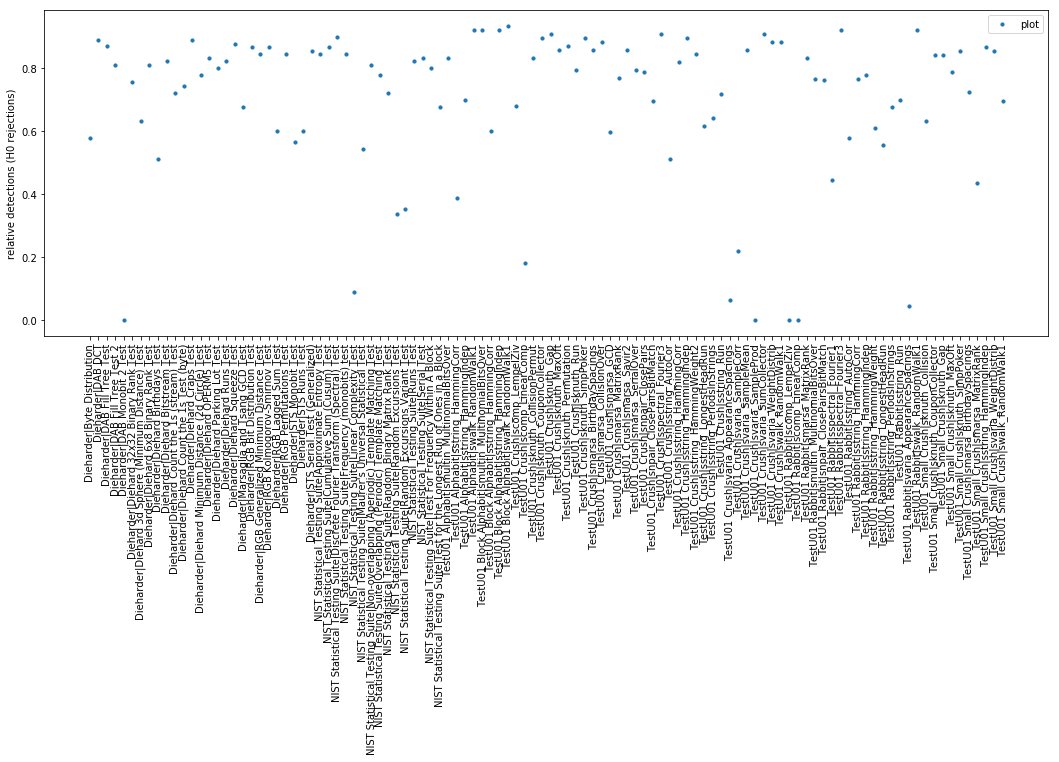

In [15]:
selection = tf_lowr8

tests_detections = get_detections(project_tests(tests_srt, tf_lowr8), 0.01)
fig, ax = pyplot.subplots(figsize=(6*3, 2*3))
ax.tick_params(axis='x', labelrotation=90)
plt.scatter([x[0] for x in tests_detections], 
            [x[1] for x in tests_detections], 
            label='plot', s=10)
plt.legend(loc='best')
ax.set_ylabel("relative detections (H0 rejections)")

In [16]:
# TODO: filter top 3 strongest and top 3 lowest tests, 10, 100 and 8 GB

In [17]:
#loader.batteries[20010].tests[200545].variants[501513].sub_tests[1081150].stats
#loader.batteries[20010].tests[200545].summarized_pvals

Total detections: 143208, defined: 90037
Alpha: 0.00100000, detections: 30044, relative: 0.3336850405944223
Alpha: 0.00500000, detections: 30880, relative: 0.34297011228717084
Alpha: 0.01000000, detections: 31565, relative: 0.3505780956717794
Alpha: 0.05000000, detections: 34610, relative: 0.3843975254617546
Alpha: 0.10000000, detections: 37578, relative: 0.41736175128002934
Alpha: 0.50000000, detections: 59149, relative: 0.656941035352133
Alpha: 1.00000000, detections: 88756, relative: 0.9857725157435276


Text(0, 0.5, 'relative detections (H0 rejections)')

2019-04-30 13:45:21 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos
2019-04-30 13:45:21 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos
2019-04-30 13:45:21 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos
2019-04-30 13:45:21 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos
2019-04-30 13:45:22 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos


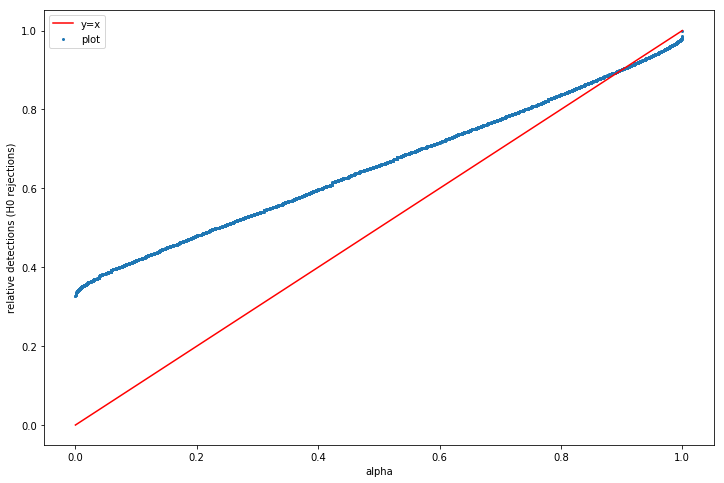

In [18]:
step =0.0001
alpha=0.0001 - step

selection = tf_100mib  # tf_100mib_rand

ctests = project_tests(tests_srt, selection)
total_det = sum(selection) * len(tests_srt)
tests_undefined = collections.defaultdict(lambda: 0)  # tname -> # of NONE in test
total_def_det = 0

# Fails removal & report
for tname, tvals in ctests:
    for idx, tval in enumerate(tvals):
        if tval is None:
            eidx = get_ex_byidx(selection, idx)
            tests_undefined[tname] += 1
            #print('%s : %s' % (tname, exps[eidx].name))
        else:
            total_def_det += 1
            
print('Total detections: %s, defined: %s' % (total_det, total_def_det))


x_data = []
y_data = []
while alpha <= 1.:
    alpha += step
    
    tests_detections = [(x[0], sum(1 for y in x[1] if y is not None and y < alpha)) for x in ctests]
    detections = sum([x[1] for x in tests_detections])
    
    if min([abs(alpha - x) for x in [0.005, 0.001, 0.01, 0.05, 0.1, 0.5, 1.]]) <= 0.000001:
        print('Alpha: %0.8f, detections: %s, relative: %s' % (alpha, detections, float(detections)/total_def_det if total_def_det > 0 else 0))
        
    x_data.append(alpha)
    #y_data.append(float(detections))
    #y_data.append(alpha / (float(detections)/total_def_det))
    #y_data.append((float(detections)/total_def_det) / alpha)
    y_data.append((float(detections)/total_def_det) if total_def_det else 0)
    
fig, ax = pyplot.subplots(figsize=(6*2, 4*2))
plt.scatter(x_data, 
            y_data, 
            label='plot', s=4)
plt.plot(x_data, x_data, label='y=x', color='red')
plt.legend(loc='best')  # plt.tick_params(labelsize=14)
ax.set_xlabel("alpha")
ax.set_ylabel("relative detections (H0 rejections)")
# TODO: compute KS

## Vertical scoring

In [19]:
# Idea: work in the test matrix in columns, count number of test reports per data set and assign points.
# Tests ranking results together.
# T1: per data: score tests. N points, divide between activated tests
# T2: per data: add tests to the set. if set exists, increment number. Which are the most often sets?
# T3: per data: triangular matrix of N tests. add +1 to a test which fired together. Which are the most firing tests?

In [20]:
selection = tf_lowr8  # tf_8gib
alpha = 0.01 

tests_scoring1 = collections.defaultdict(lambda: 0)
tests_scoring2 = collections.defaultdict(lambda: 0)
tests_scoring_eq = collections.defaultdict(lambda: 0)
tests_sets = collections.defaultdict(lambda: 0)
tests_matrix = [[0]*len(tests_srt) for i in range(len(tests_srt))]
tests_matrix_2 = [[0]*len(tests_srt) for i in range(len(tests_srt))]

ctests = project_tests(tests_srt, selection)
total_det = sum(selection) * len(tests_srt)
tests_undefined = collections.defaultdict(lambda: 0) 
num_tests = len(ctests)

for col in range(len(ctests[0][1])):
    num_defined = sum(1 for i in range(num_tests) if ctests[i][1][col] is not None)
    detections = [i for i in range(num_tests) if ctests[i][1][col] is not None and ctests[i][1][col] < alpha]
    num_detections = len(detections)
    
    # T1
    points_to_add1 = num_defined // num_detections if num_detections > 0 else 0
    points_to_add2 = num_defined // (num_defined-num_detections) if num_defined != num_detections > 0 else 0
    for ti in range(num_tests):
        tests_scoring_eq[ti] += points_to_add1 if ti in detections else points_to_add2
        tests_scoring1[ti] += points_to_add1 if ti in detections else 0
        tests_scoring2[ti] += 0 if ti in detections else points_to_add2
        
    # T2
    tests_sets[tuple(detections)] += 1
    
    # T3
    for ti in detections:
        for ti2 in detections:
            if ti > ti2:
                continue
            tests_matrix[ti][ti2] += 1
    
    pairs = set([(i, j) for i,j in itertools.product(detections, detections) if i<=j])
    for i in range(len(ctests)):
        for j in range(i, len(ctests)):
            if (i,j) not in pairs:
                tests_matrix_2[i][j] += 1


In [21]:
# Scoring by rounds achieved
def round_scoring(exps, tests_srt, selection, alpha=0.01, desc=None):
    ctests = project_tests(tests_srt, selection)
    total_det = sum(selection) * len(tests_srt)
    tests_undefined = collections.defaultdict(lambda: 0) 
    num_tests = len(ctests)

    fnc_rounds = get_rounds(exps)
    f2r = collections.defaultdict(lambda: [])  # fname -> rounds[] -> exp IDs
    for ix, x in enumerate(exps):
        f2r[x.exp_info.fnc_name].append((x, ix))

    f2r_map = {fname: sorted(f2r[fname], key=lambda x: (x[0].exp_info.fnc_round, x[0].exp_info.meth)) for fname in f2r}

    # testidx -> fname -> top round achieved
    test_rounds = collections.defaultdict(
        lambda: collections.defaultdict(
            lambda: -1))
    
    test_occurences = collections.defaultdict(lambda: 0)
    test_undefined = collections.defaultdict(lambda: 0)
    test_undefineds = collections.defaultdict(lambda: [])
    test_defined = collections.defaultdict(lambda: 0)
    test_detected = collections.defaultdict(lambda: 0)
    
    for fname in f2r_map:
        for exp, exid in f2r_map[fname]:
            nexid = get_ex_newidx(selection, exid)  # after compression by selection
            if nexid is None:
                continue
                
            fround = exp.exp_info.fnc_round
            for testid in range(len(ctests)):
                tname = ctests[testid][0]
                pvals = ctests[testid][1]
                
                test_occurences[testid] += 1
                if pvals[nexid] is None:
                    test_undefined[testid] += 1
                    test_undefineds[testid].append(exp)
                else:
                    test_defined[testid] += 1
                    
                if pvals[nexid] is not None and pvals[nexid] < alpha:
                    test_detected[testid] += 1
                    test_rounds[testid][fname] = max(fround, test_rounds[testid][fname])
    
    max_points = 0
    for fname in f2r_map:
        fr = fnc_rounds[fname]
        maxr = max(fr)
        minr = min(fr)
        max_points += 1 + (maxr - minr)
    print('Max points: %s' % max_points)
    
    tis = collections.defaultdict(lambda: [])
    for fname in f2r_map:
        fr = fnc_rounds[fname]
        maxr = max(fr)
        minr = min(fr)   
        maxdet = max([test_rounds[testid][fname] for testid in range(len(ctests))])
        tis['%s|r%s' % (fname, maxdet)] = [t[0] for ix, t in enumerate(ctests) if test_rounds[ix][fname] == maxdet]
    #print(json.dumps(tis, indent=2))
    
    #print(json.dumps(test_rounds, indent=2))
    tests_scoring_r = collections.defaultdict(lambda: 0)
    for fname in f2r_map:
        fr = fnc_rounds[fname]
        maxr = max(fr)
        minr = min(fr)        
        for testid in range(len(ctests)):
            if test_rounds[testid][fname] < 0 or test_rounds[testid][fname] is None:
                continue
            points = 1 * (1 + (test_rounds[testid][fname] - minr))
            tests_scoring_r[tests_srt[testid][0]] += points
            
    #print(json.dumps(tests_scoring_r, indent=2))
    
    fig, ax = pyplot.subplots(figsize=(6*3, 2*3))
    ax.tick_params(axis='x', labelrotation=90)
    
    acc_data = [(x[0], tests_scoring_r[x[0]]) for x in ctests]
    acc_data.sort(key=lambda x: (x[1], x[0]))

    #sns.barplot(x=[x[0] for x in ctests], y=[tests_scoring_r[x[0]] for x in ctests])
    sns.barplot(x=[x[0] for x in acc_data], y=[x[1] for x in acc_data])
    ax.set_ylabel("test scoring (on detected function rounds) %s" % (desc if desc else ''))
    
    print(acc_data)
    for ix, x in enumerate(ctests):
        print('Records: %s  Undefined: %s Defined: %s Detections: %s %s  %s' 
              % (test_occurences[ix], test_undefined[ix], test_defined[ix], test_detected[ix], x[0],
                 json.dumps([str(x) for x in test_undefineds[ix]], indent=2)))
    #plt.savefig("/tmp/sorted.png", bbox_inches='tight', dpi=800)

Max points: 185


2019-04-30 13:45:23 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos


[('Dieharder|DAB Monobit 2 Test', 0), ('TestU01 Crush|svaria_SampleProd', 0), ('TestU01 Rabbit|scomp_LempelZiv', 2), ('TestU01 Rabbit|scomp_LinearComp', 2), ('NIST Statistical Testing Suite|Linear Complexity Test', 9), ('TestU01 Rabbit|svaria_AppearanceSpacings', 15), ('TestU01 Crush|svaria_AppearanceSpacings', 19), ('TestU01 Crush|scomp_LinearComp', 23), ('NIST Statistical Testing Suite|Random Excursions Variant Test', 29), ('NIST Statistical Testing Suite|Random Excursions Test', 39), ('TestU01 Crush|sstring_LongestHeadRun', 44), ('TestU01 Rabbit|sstring_LongestHeadRun', 46), ('TestU01 Rabbit|sspectral_Fourier1', 47), ('TestU01 Alphabit|sstring_HammingCorr', 49), ('TestU01 Small Crush|smarsa_MatrixRank', 50), ('TestU01 Crush|smarsa_GCD', 56), ('TestU01 Crush|scomp_LempelZiv', 60), ('NIST Statistical Testing Suite|Random Binary Matrix Rank Test', 63), ('Dieharder|Diehard 32x32 Binary Rank Test', 64), ('Dieharder|Diehard Birthdays Test', 64), ('TestU01 Crush|svaria_SampleCorr', 65), ('

2019-04-30 13:45:24 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos
2019-04-30 13:45:25 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos
2019-04-30 13:45:27 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos
2019-04-30 13:45:27 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos


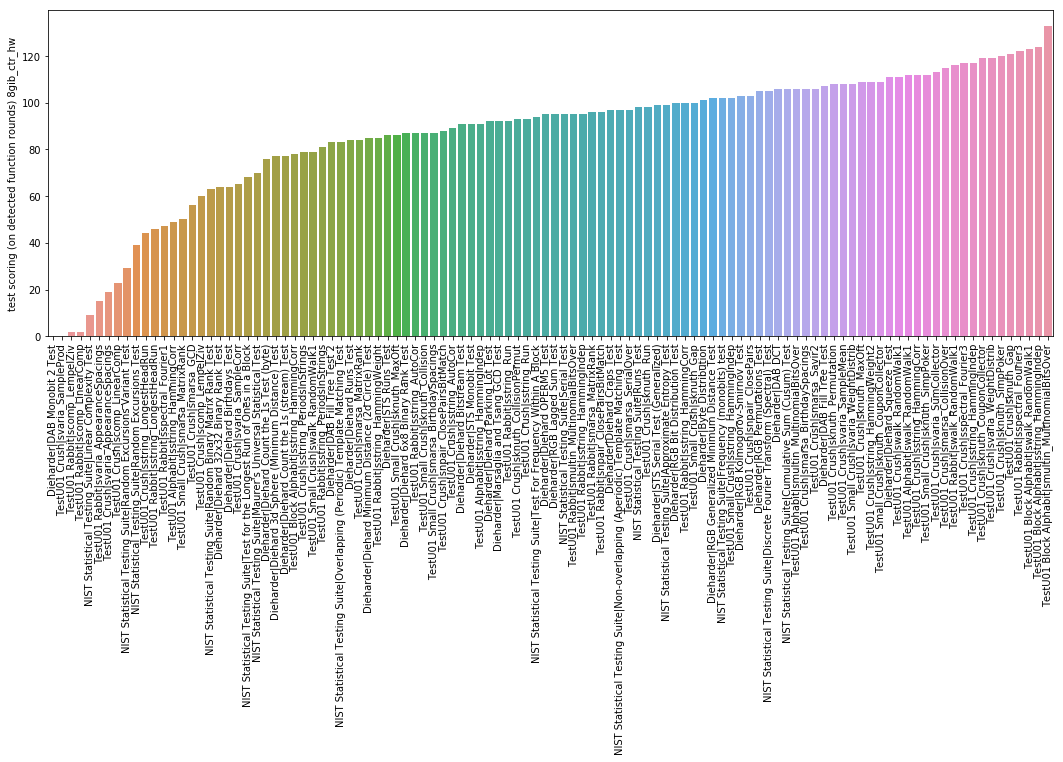

In [22]:
round_scoring(exps, tests_srt, tf_8gib_ctr_hw, alpha=0.001, desc='8gib_ctr_hw')  # tf_8gib

In [23]:
sum(tf_8gib_ctr_hw)

294

Text(0, 0.5, 'test scoring (the better the more unique appearances)')

2019-04-30 13:45:29 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos
2019-04-30 13:45:30 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos
2019-04-30 13:45:31 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos
2019-04-30 13:45:33 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos
2019-04-30 13:45:33 aura.fi.muni.cz matplotlib.axes._base[119329] DEBUG update_title_pos


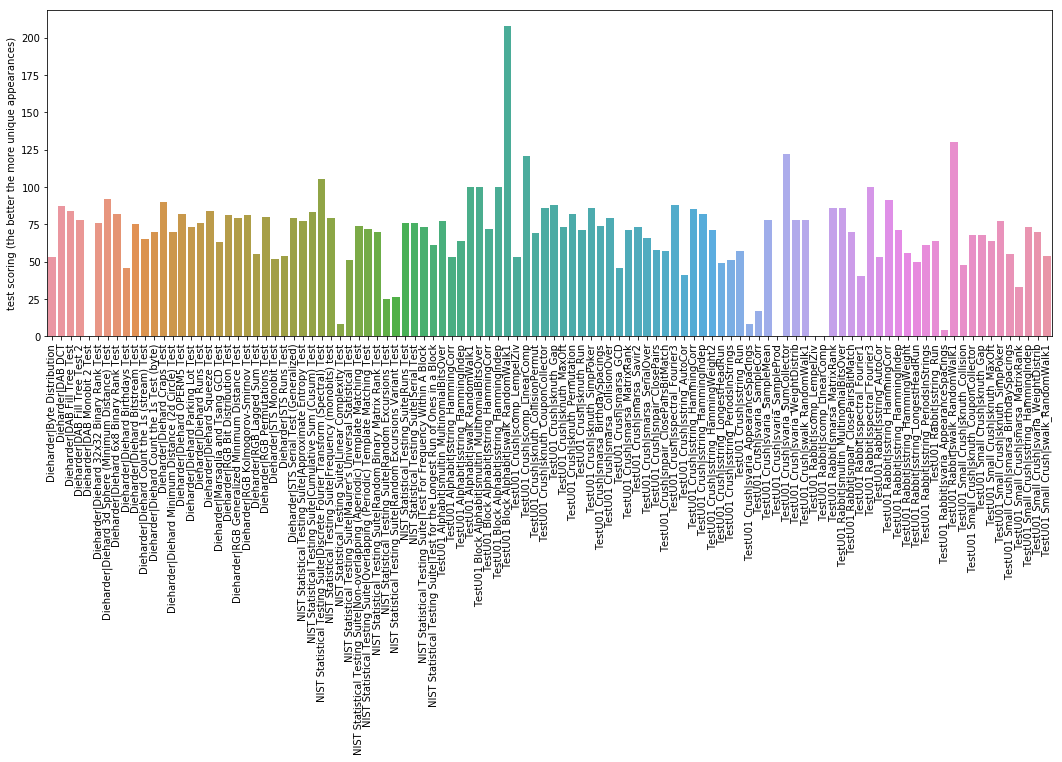

In [24]:
# T1 test uniqueness scoring
fig, ax = pyplot.subplots(figsize=(6*3, 2*3))
ax.tick_params(axis='x', labelrotation=90)

sns.barplot(x=[x[0] for x in ctests], y=[tests_scoring1[x] for x in range(len(ctests))])
ax.set_ylabel("test scoring (the better the more unique appearances)")

In [25]:
# T2: test sets
tests_sets_l = sorted([(k, tests_sets[k]) for k in tests_sets if tests_sets[k]>=2], reverse=True)
print(tests_sets_l[:10])

[((0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 77, 79, 80, 81, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107), 2), ((0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97), 2), ((0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97), 2), ((0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36,

In [26]:
# T3: matrix

In [27]:
print(tests_matrix_2)

[[38, 38, 43, 40, 90, 44, 43, 41, 46, 40, 42, 43, 38, 41, 39, 38, 39, 38, 41, 38, 38, 38, 40, 38, 42, 42, 38, 39, 39, 38, 39, 82, 46, 40, 39, 45, 66, 68, 39, 39, 39, 44, 38, 57, 39, 38, 38, 40, 38, 38, 54, 77, 52, 51, 50, 51, 52, 51, 51, 50, 50, 55, 51, 51, 51, 58, 58, 50, 54, 50, 50, 51, 58, 52, 50, 89, 74, 52, 90, 51, 50, 50, 90, 90, 39, 41, 46, 50, 38, 40, 41, 38, 40, 49, 41, 38, 89, 38, 58, 53, 53, 55, 54, 54, 60, 52, 52, 54], [0, 10, 17, 18, 90, 24, 34, 19, 44, 16, 25, 23, 11, 20, 17, 18, 16, 11, 29, 12, 14, 12, 36, 15, 39, 36, 13, 14, 12, 10, 14, 82, 42, 17, 20, 26, 65, 64, 16, 15, 18, 29, 15, 56, 27, 10, 10, 37, 10, 10, 37, 77, 25, 23, 22, 24, 25, 30, 23, 25, 22, 44, 32, 24, 29, 34, 38, 22, 50, 27, 22, 24, 42, 40, 34, 86, 73, 25, 90, 23, 22, 22, 90, 90, 17, 22, 24, 50, 10, 38, 23, 20, 35, 40, 29, 27, 86, 10, 42, 26, 26, 30, 27, 35, 57, 25, 25, 37], [0, 0, 15, 21, 90, 28, 38, 22, 48, 21, 30, 28, 17, 25, 20, 24, 21, 17, 35, 18, 20, 18, 41, 20, 44, 40, 19, 19, 18, 17, 19, 83, 45, 2

In [28]:
G = nx.Graph()
G2 = Graph('G')
for t in ctests:
    G.add_node(t[0])

for i in range(len(ctests)):
    for j in range(i+1, len(ctests)):
        w = tests_matrix[i][j]
        if w < 75:
            continue
            
        print("%s - %s [%s]" % (ctests[i][0], ctests[j][0], w))
        G.add_edge(ctests[i][0], ctests[j][0], weight=w, color='green' if w<=5 else 'black', size=10 if w<=5 else 2)
        G2.edge(str(ctests[i][0]), str(ctests[j][0]), penwidth=('%s' % (w-74))) # weight=w)

#print(json.dumps([list(x) for x in nx.connected_components(G)], indent=2))

Dieharder|DAB DCT - Dieharder|Diehard Craps Test [79]
Dieharder|DAB DCT - Dieharder|Diehard Squeeze Test [79]
Dieharder|DAB DCT - Dieharder|RGB Bit Distribution Test [78]
Dieharder|DAB DCT - Dieharder|RGB Generalized Minimum Distance Test [76]
Dieharder|DAB DCT - Dieharder|RGB Kolmogorov-Smirnov Test [78]
Dieharder|DAB DCT - Dieharder|RGB Permutations Test [75]
Dieharder|DAB DCT - Dieharder|STS Serial Test (Generalized) [77]
Dieharder|DAB DCT - NIST Statistical Testing Suite|Approximate Entropy Test [76]
Dieharder|DAB DCT - NIST Statistical Testing Suite|Cumulative Sum (Cusum) Test [78]
Dieharder|DAB DCT - NIST Statistical Testing Suite|Discrete Fourier Transform (Spectral) Test [80]
Dieharder|DAB DCT - NIST Statistical Testing Suite|Frequency (monobits) test [76]
Dieharder|DAB DCT - NIST Statistical Testing Suite|Serial Test [75]
Dieharder|DAB DCT - TestU01 Alphabit|smultin_MultinomialBitsOver [75]
Dieharder|DAB DCT - TestU01 Alphabit|swalk_RandomWalk1 [80]
Dieharder|DAB DCT - TestU01

In [ ]:
G2.engine = 'circo'
#G2.engine = 'neato'
#G2.engine = 'fdp'
#G2.engine = 'osage'
###G2.engine = 'patchwork'
#G2.engine = 'sfdp'
#G2.engine = 'twopi'
G2.view()

In [ ]:
plt.figure(figsize=(24, 24))
#nx.draw_networkx(G, with_labels=True)
#nx.draw(G, with_labels=True)
nx.draw(G, with_labels=True, pos=nx.circular_layout(G))
#nx.draw(G, with_labels=True, pos=nx.kamada_kawai_layout(G))
#nx.draw(G, with_labels=True, pos=nx.shell_layout(G, shells))
#nx.draw(self.G, with_labels=True, pos=mylay(self.shells))
#plt.savefig("/tmp/deps.png", dpi=400)

In [30]:
a=[1,2,3,4,5,6]
print(list(itertools.product(a,a)))

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]


In [31]:
def sidak_alpha(alpha, m):
    return 1 - (1 - alpha)**(1./m)


def sidak_inv(alpha, m):
    return 1 - (1 - alpha)**m


def chunks(items, size):
    for i in range(0, len(items), size):
        yield items[i : i + size]


def merge_pvals(pvals, batch=2):
    if len(pvals) <= 1:
        return pvals
    
    batch = min(max(2, batch), len(pvals))  # norm batch size
    parts = list(chunks(pvals, batch))
    exponent = len(pvals) / len(parts)
    npvals = []
    for p in parts:
        pi = sidak_inv(min(p), exponent)
        npvals.append(pi)
    # print(npvals, [len(x) for x in parts])
    return merge_pvals(npvals, batch)
    

In [32]:
# SIDAK TEST
alpha= 0.0085 #.015  # .005
pvals=[.03, .5, .21, ] + [0.001, 0.11, 0.99,]
nvals=[.07, .02, .002009, 0.98, 0.55,   0.0001 ]
ns_ex=sidak_alpha(alpha, len(nvals))
ns_cp=sidak_alpha(min(nvals), len(nvals))
nsicp=sidak_inv(min(nvals), len(nvals))
         
print('alpha: %s' % alpha)
print('min p: %s' % min(nvals))
print('sh  t: %s, %s' % (ns_ex, min(nvals) < ns_ex))
print('shi p: %s, %s' % (nsicp, nsicp < alpha))
print('')

t1 = pvals+nvals
a1 = sidak_alpha(alpha, len(t1))
print(min(t1), a1, min(t1) < a1, len(t1), "\n")

t2 = pvals+[sidak_inv(min(nvals), len(nvals))]
a2 = sidak_alpha(alpha, len(t2))
print(min(t2), a2, min(t2) < a2, len(t2), "\n")

dexp = (len(t1)) / (len(pvals)+1.)
Y = 1-(1-min(t1))**(dexp)
t3 = pvals+[Y]
a3 = sidak_alpha(alpha, len(t3))
print(Y)
print(min(t3), a2, min(t3) < a3, len(t3), "\n")
#print(sidak_inv(0.1, 5))
#print(sidak_inv(0.01, 5))

#random.shuffle(t1)
print('='*80)
print('LEN: %s' % len(t1))
ideal = merge_pvals(t1, 999)
print('M: ', ideal) # FULL merge
#ammend(t1)
#print('M: ', merge_pvals(t1, 999)) # FULL merge
print('M: ', merge_pvals(t1, 2))
print('M: ', merge_pvals(t1, 3))
print('M: ', merge_pvals(t1, 4))
print('M: ', merge_pvals(t1, 5))
print('M: ', merge_pvals(t1, 6))
print('M: ', merge_pvals(t1, 7))
print('M: ', merge_pvals(t1, 8))
print('M: ', merge_pvals(t1, 9))
print('M: ', merge_pvals(t1, 10))

alpha: 0.0085
min p: 0.0001
sh  t: 0.0014217102481283161, True
shi p: 0.0005998500199984047, True

0.0001 0.0007111079613304483 True 12 

0.0005998500199984047 0.0012187326017989442 True 7 

0.00017142244892121017
0.00017142244892121017 0.0012187326017989442 True 7 

LEN: 12
M:  [0.0011993402199503844]
M:  [0.0011993402199500514]
M:  [0.0011993402199504954]
M:  [0.0011993402199504954]
M:  [0.0011993402199504954]
M:  [0.0011993402199502734]
M:  [0.0011993402199502734]
M:  [0.0011993402199502734]
M:  [0.0011993402199502734]
M:  [0.0011993402199502734]


In [33]:
res_chars = {
    "False|Anderson-Darling (A2)|Kolmogorov-Smirnov (D+)|Kolmogorov-Smirnov (D-)|Std empirical corr|Std empirical mean": 12372,
    "False|Chi-square": 49314,
    "False|Normal": 19811,
    "False|Chi-square(C)|Chi-square(H)|Chi-square(J)|Chi-square(M)|Chi-square(R)": 25980,
    "True|Chi-Square": 247182,
    "False|Collision": 10350,
    "False|Bit distance": 3489,
    "False|Chi-square|Normal": 3042,
    "False|Anderson-Darling|Kolmogorov-Smirnov (D+)|Kolmogorov-Smirnov (D-)": 2613,
    "False|Chi-square|Global longest run of 1": 2184,
    "False|Anderson-Darling|Kolmogorov-Smirnov (D+)|Kolmogorov-Smirnov (D-)|Normal|Sample variance": 3029,
    "False|Anderson-Darling (A2) (bits)|Anderson-Darling (A2) (runs)|Chi-square (runs)|Kolmogorov-Smirnov (D+) (bits)|Kolmogorov-Smirnov (D+) (runs)|Kolmogorov-Smirnov (D-) (bits)|Kolmogorov-Smirnov (D-) (runs)|Normal (bits)|Sample variance (bits)": 442,
    "False|Anderson-Darling|Chi-square": 1724,
    "True|Kolmogorov-Smirnov": 121542,
    "False|A2 (m-NP)|A2 (mNP1)|AD (NP)|AD (mNP2)|Jumps Y (mN)": 413,
    "False|A2 (m-NP)|A2 (mNP1)|AD (NP)|AD (mNP2)|AD (mNP2-S)|Jumps Y (mN)": 824,
    "False|Anderson-Darling - AD (A2)|Anderson-Darling - KS (D+)|Anderson-Darling - KS (D-)|Chi-square - AD (A2)|Chi-square - KS (D+)|Chi-square - KS (D-)|Observations sums": 858,
    "False|Anderson-Darling": 858,
    "False|Anderson-Darling|Chi-square|Kolmogorov-Smirnov (D+)|Kolmogorov-Smirnov (D-)": 858,
    "False|Unknown 0|Unknown 1|Unknown 2|Unknown 3": 1,
    "False|Unknown 0": 26520,
    "False|Unknown 0|Unknown 1": 884
}

In [34]:
chi=0
kolm=0
ander=0
other=0
for k in res_chars:
    kl = k.lower()
    if 'chi' in kl:
        chi+=res_chars[k]
    elif 'kolm' in kl:
        kolm+=res_chars[k]
    elif 'ander' in kl:
        ander+=res_chars[k]
    else:
        other+=res_chars[k]
        
print(chi, kolm, ander,other)

331584 139556 858 62292


In [35]:
picked_sum = collections.defaultdict(lambda: 0)
for tt in loader.tests.values():
    
    tt_id = '|'.join(reversed(tt.short_desc()))
    for vv in tt.variants.values():
        cfv = '|'.join([str(x) for x in vv.settings.values_tuple()])

        for ss in vv.sub_tests.values():
            tfv = '|'.join([str(x) for x in ss.params.values_tuple()])
            if len(ss.stats) == 0:
                logger.debug('Null statistics for test %s:%s:%s' % (tt_id, cfv, tfv))
                continue

            picked = dump_data.pick_one_statistic(ss.stats)
            picked_sum[picked.name] += 1

print(json.dumps(picked_sum, indent=2))       

{
  "Kolmogorov-Smirnov (D+)": 20646,
  "Chi-square": 122922,
  "Normal": 54027,
  "Chi-square(C)": 72040,
  "Chi-Square": 738904,
  "Collision": 15612,
  "Bit distance": 8749,
  "Chi-square (runs)": 442,
  "Kolmogorov-Smirnov": 338682,
  "AD (NP)": 1237,
  "Chi-square - AD (A2)": 858,
  "Anderson-Darling": 858,
  "Unknown 0": 108997
}


In [48]:
def process_extended(tests, add_all=False, pick_one=False, add_passed=True):
    for tt in tests.values():
        tt_id = '|'.join(reversed(tt.short_desc()))
        tt.summarized_pvals = []
        tt.summarized_passed= []

        for vv in tt.variants.values():
            # cfs = '|'.join([str(x) for x in vv.settings.keys_tuple()])
            cfv = '|'.join([str(x) for x in vv.settings.values_tuple()])

            for ss in vv.sub_tests.values():
                # tfs = '|'.join([str(x) for x in ss.params.keys_tuple()])
                tfv = '|'.join([str(x) for x in ss.params.values_tuple()])
                if len(ss.stats) == 0:
                    logger.debug('Null statistics for test %s:%s:%s' % (tt_id, cfv, tfv))
                    continue

                if not add_all and pick_one:
                    picked = pick_one_statistic(ss.stats)
                    #self.picked_stats[picked.name] += 1
                
                desc = '{vid:%s|cfg:%s}{subid:%s|cfg:%s}' % (vv.id, cfv, ss.id, tfv)
                picked_stats = loader.pick_stats(ss.stats, add_all=add_all, pick_one=pick_one)
                picked_pvals = [x.value for x in picked_stats]
                picked_pass = [(x.passed, desc) for x in picked_stats]

                # Sidak postprocessing.
                # Compute resulting p-value from all pvalues in collected stats.
                # If pvalues are independent, result are better and we can compute one final pvalue.
                # WARNING: this strategy does not work well if resulting tree is unbalanced.
                #          It has to be perfectly symmetric.
                if not add_all and not pick_one:
                    picked_pvals = [sidak_inv(min(picked_pvals), len(picked_pvals))]
                    picked_pass = []

                tt.summarized_pvals += picked_pvals
                if add_passed:
                    tt.summarized_passed += picked_pass
                    
process_extended(loader.tests, add_all=True, add_passed=True)

In [49]:
# Syso json
# tests[test-name][experiment-name:size-meth-fnc-round]
# tests = [test-name][exp-idx] -> pvalue

tests_mult = collections.defaultdict(lambda: [None] * len(exps))
for tt in loader.tests.values():
    tt_id = '|'.join(reversed(tt.short_desc()))
    tests_mult[tt_id][rev_exp[tt.battery.exp.name]] = list(zip(tt.summarized_pvals, tt.summarized_passed))

sys_grouper = lambda x: (x.size, x.meth, x.fnc_name, x.fnc_round)
exps_sys = sorted(exps, key=lambda x: sys_grouper(x.exp_info))

tests_to_use = tests_mult
tests_sys = collections.defaultdict(lambda: collections.defaultdict(lambda: list))
for ti, tt in enumerate(tests_to_use):
    
    # Sort so the experiments that should be grouped are next to each other. Only for valid pvalues (test finished)
    cur = sorted([(eidx, pval) for eidx, pval in enumerate(tests_to_use[tt]) if pval is not None], key=lambda x: sys_grouper(exps[x[0]].exp_info))
    
    # Group by the experiments with same size-meth-fnc-round
    for k, g in itertools.groupby(cur, key=lambda x: sys_grouper(exps[x[0]].exp_info)):
        ckey = '|'.join([str(x) for x in k])
        tests_sys[tt][ckey] = [x[1] for x in list(g)]
    
json.dump(tests_sys, open('syso-secmargin-pvals.json', 'w+'), indent=2)


In [39]:
json.dump(tests_mult, open('sysotmp.json', 'w+'), indent=2)

In [40]:
print([list(x.sub_tests.values()) for x in list(list(loader.tests.values())[0].variants.values())][0][0].stats[0].passed)

False
